# EDA: APS Fault Detection 

### Problem Statement:
* The Air Pressure System generates pressurized air that are utilized in various functions in heavy duty vehicles, such as braking and gear changes. 
* The dataset' positive class corresponds to the truck failures for a specific component of the APS System. The negative class corresponds to the truck with failures not related for components not reltaed to the APS System.
* The problem is to reduce the cost due to unnecessary repairs. So it is required to minimize the false predictions.

### Total Cost:

* The total cost of the prediction model is the sum of the cost_1 multiplied by the number of instances with the type 1 error and cost_2 multiplied by the number of instances with the type 2 error. cost_1 refers to the cost that an unnecessary check needs to be done by a mechanic at a workshop and cost_2 refers to the cost of missing a faulty truck which may lead to the breakdown of the truck.
* Total Cost = (cost_1 * no_instances) + (cost_2 * no_instances) ; assuming cost_1 as 10 and cost_2 as 500
* From the above problem we could observe that we need to reduce false positives and false negatives, more importantly false negatives since cost incurred due to false negative is 50 times higher than false positive.

### Challenges and Objectives:
* Need to handle many null values in almost all columns.
* Low latency requirements.
* Interpretability is not important.
* Misclassification leads tonn unnecessary repair costs.

##### Import Required Dependencies 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statistics import mean
from sklearn.preprocessing import PowerTransformer, LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.impute import SimpleImputer, KNNImputer

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

##### Read Data and Identify Target Column

In [3]:
df = pd.read_csv("aps_failure_training_set.csv", na_values="na")

In [4]:
df.head()

,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,...,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
0,neg,76698,NaN,2.130706e+09,280.0,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,neg,33058,NaN,0.000000e+00,NaN,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,neg,41040,NaN,2.280000e+02,100.0,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,neg,12,0.0,7.000000e+01,66.0,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,neg,60874,NaN,1.368000e+03,458.0,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0


In [5]:
df.shape

(60000, 171)

In [6]:
df["class"].value_counts()

class
neg    59000
pos     1000
Name: count, dtype: int64

In [7]:
numerical_features = [feature for feature in df.columns if df[feature].dtype != "O"]
categorical_features = [feature for feature in df.columns if df[feature].dtype == "O"]

print(f"We have {len(numerical_features)} numerical features: {numerical_features}")
print(f"We have {len(categorical_features)} numerical features: {categorical_features}")

We have 170 numerical features: ['aa_000', 'ab_000', 'ac_000', 'ad_000', 'ae_000', 'af_000', 'ag_000', 'ag_001', 'ag_002', 'ag_003', 'ag_004', 'ag_005', 'ag_006', 'ag_007', 'ag_008', 'ag_009', 'ah_000', 'ai_000', 'aj_000', 'ak_000', 'al_000', 'am_0', 'an_000', 'ao_000', 'ap_000', 'aq_000', 'ar_000', 'as_000', 'at_000', 'au_000', 'av_000', 'ax_000', 'ay_000', 'ay_001', 'ay_002', 'ay_003', 'ay_004', 'ay_005', 'ay_006', 'ay_007', 'ay_008', 'ay_009', 'az_000', 'az_001', 'az_002', 'az_003', 'az_004', 'az_005', 'az_006', 'az_007', 'az_008', 'az_009', 'ba_000', 'ba_001', 'ba_002', 'ba_003', 'ba_004', 'ba_005', 'ba_006', 'ba_007', 'ba_008', 'ba_009', 'bb_000', 'bc_000', 'bd_000', 'be_000', 'bf_000', 'bg_000', 'bh_000', 'bi_000', 'bj_000', 'bk_000', 'bl_000', 'bm_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'bs_000', 'bt_000', 'bu_000', 'bv_000', 'bx_000', 'by_000', 'bz_000', 'ca_000', 'cb_000', 'cc_000', 'cd_000', 'ce_000', 'cf_000', 'cg_000', 'ch_000', 'ci_000', 'cj_000', 'ck_000',

##### Checking Missing Values

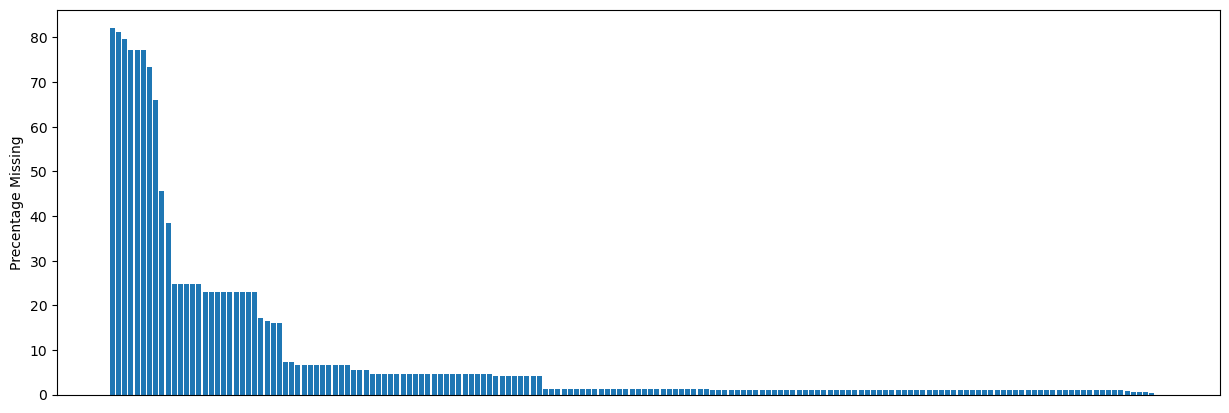

In [8]:
fig, ax = plt.subplots(figsize=(15, 5))
missing = df.isna().sum().div(df.shape[0]).mul(100).to_frame().sort_values(by=0, ascending=False)
ax.bar(missing.index, missing.values.T[0])
plt.xticks([])
plt.ylabel("Precentage Missing")
plt.show()

Dropping columns which has more than 70% of missing values

In [9]:
dropcols = missing[missing[0]>70]
dropcols

,0
br_000,82.106667
bq_000,81.203333
bp_000,79.566667
bo_000,77.221667
ab_000,77.215000
cr_000,77.215000
bn_000,73.348333


In [10]:
df.drop(list(dropcols.index), axis=1, inplace=True)
df.shape

(60000, 164)

Checking total percentage of missing values of dataset after dropping columns with more than 70% of missing values.

In [11]:
missing_values_count = df.isnull().sum()
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()

print(f"Percentage of total missing cells in the data are: {(total_missing/total_cells)*100}%")

Percentage of total missing cells in the data are: 5.29765243902439%


##### Vizualization of Unique Values in Target Variable

Positive: 1000
Negative: 59000


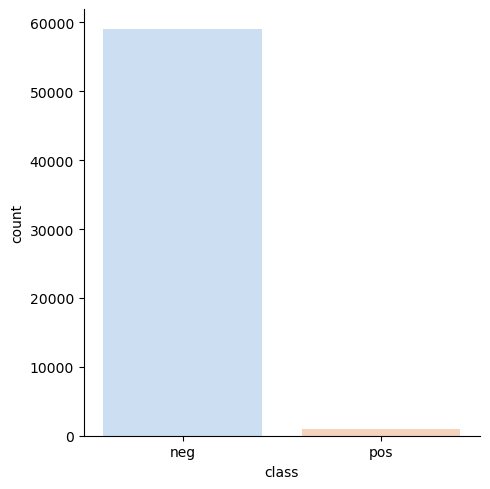

In [12]:
pos = df[df["class"] == "pos"].shape[0]
neg = df[df["class"] == "neg"].shape[0]

print(f"Positive: {pos}")
print(f"Negative: {neg}")

sns.catplot(data=df, x="class", kind="count", palette="pastel", alpha=0.6)
plt.show()


##### Report:
* The target class is highly imbalanced ie. the number of data points in the negative class (majority class) is much higher compared to the number of data points in the positive class (minority class)
* if the imbalanced data is not treated beforehand, then this will degrade the performance of the classifier model. Hence, we need to handle the imbalanced data with certain techniques.

##### Handling Imbalanced Data
* Resampling: There are two techniques, oversampling and undersampling. Oversampling is preferred in most cases since we tend to remove instances from data that may be carrying some important features.
* SMOTE: An oversampling technique where synthetic data is generated for the minority class.
* Hybridization: This involves combining both undersampling and oversampling to optimize the performance of the classifier model for the samples created. It only duplicates data and won't add new information. 

##### Creating Functions for Model Training and Evaluation

In [13]:
def evaluate_clf(true, predicted):
    """
    This function takes true values and predicted values.
    Returns: Accuracy, Precison, Recall, F1-Score, Roc-Auc-Score
    """
    acc = accuracy_score(true, predicted)
    precision = precision_score(true, predicted)
    recall = recall_score(true, predicted)
    f1 = f1_score(true, predicted)
    roc_auc = roc_auc_score(true, predicted)
    return acc, precision, recall, f1, roc_auc 

In [14]:
def total_cost(y_true, y_pred):
    """
    This function takes y_true and y_pred values.
    Returns: Total cost due to misclassification.
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = (10 * fp) + (50 * fn)
    return cost 

In [15]:
def evaluate_models(X, y, models):
    """
    This function takes X, y and models dictionary.
    Splits the data into train and test and iterates through the models dictionary to evaluate the metrics.
    Returns: Dataframe that contains report of all models metrics with cost.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    cost_list = []
    accuracy_list = []
    models_list = []

    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train)
        
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        model_train_accuracy, model_train_precision, model_train_recall, model_train_f1, model_train_roc_auc = evaluate_clf(y_train, y_train_pred)
        model_test_accuracy, model_test_precision, model_test_recall, model_test_f1, model_test_roc_auc = evaluate_clf(y_test, y_test_pred)

        train_cost = total_cost(y_train, y_train_pred)
        test_cost = total_cost(y_test, y_test_pred)

        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print("Model performance for training set")
        print("Accuracy: {:.4f}".format(model_train_accuracy))
        print("Precision: {:.4f}".format(model_train_precision))
        print("Recall: {:.4f}".format(model_train_recall))
        print("F1-Score: {:.4f}".format(model_train_f1))
        print("ROC-AuUC-Score: {:.4f}".format(model_train_roc_auc))
        print(f"Cost: {train_cost}")

        print("-----------------------------------------------------")

        print("Model performance for testing set")
        print("Accuracy: {:.4f}".format(model_test_accuracy))
        print("Precision: {:.4f}".format(model_test_precision))
        print("Recall: {:.4f}".format(model_test_recall))
        print("F1-Score: {:.4f}".format(model_test_f1))
        print("ROC-AuUC-Score: {:.4f}".format(model_test_roc_auc))
        print(f"Cost: {test_cost}")

        cost_list.append(test_cost)
        print("="*35)
        print("\n")

    report = pd.DataFrame(list(zip(models_list, cost_list)), columns=["Model Name", "Cost"]).sort_values(by=["Cost"])

    return report


##### Plot Distribution of all Independent Variables

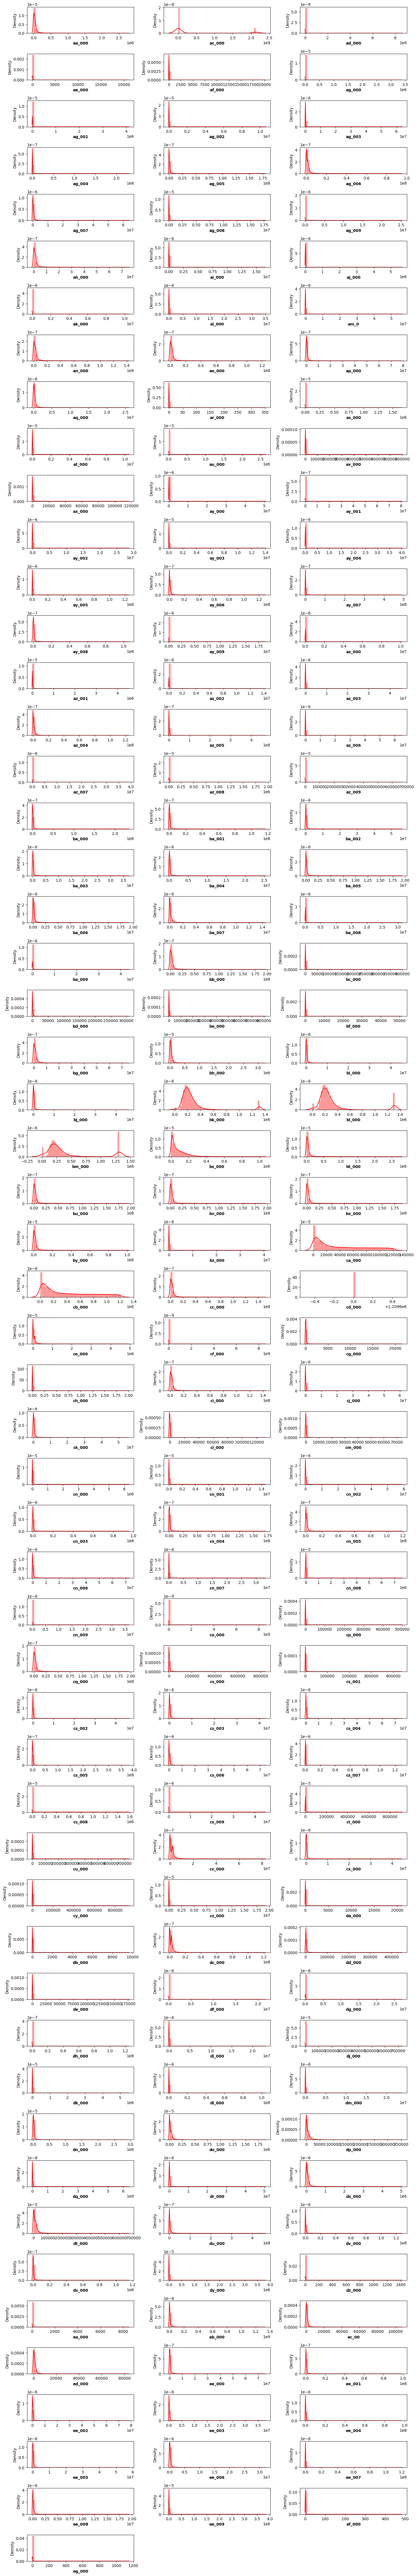

In [16]:
numerical_features = [feature for feature in df.columns if df[feature].dtype != "O"]

plt.figure(figsize=(15, 100))
for i, col in enumerate(numerical_features):
    plt.subplot(60, 3, i+1)
    sns.distplot(x=df[col], color="red")
    plt.xlabel(col, weight="bold")
    plt.tight_layout()

##### Report:
* As per the above plot most of the columns are not normally distributed.
* Transformation of the data is not necessary as it is a classification problem.
* Interpretation of the data is not necessary as it is sensor data.

##### Evaluate Model on Different Experiments

In [17]:
X = df.drop("class", axis=1)
y = df["class"]

In [18]:
y = y.replace({"pos": 1, "neg": 0})

##### Experiment 1: KNN Imputer for Null Values

In [19]:
robustscaler = RobustScaler()
X1 = robustscaler.fit_transform(X)

Finding optimal n_neighbour value for KNN Imputer

In [20]:
results = []
imputer = KNNImputer(n_neighbors=5, weights="uniform", metric="nan_euclidean")
strategies = [str(i) for i in [1, 3, 5, 7, 9]]
for s in strategies:
    pipeline = Pipeline(steps=[("i", KNNImputer(n_neighbors=int(s))), ("m", LogisticRegression())])
    scores = cross_val_score(pipeline, X1, y, scoring="accuracy", cv=2, n_jobs=-1)
    results.append(scores)
    print("n_neighbors= %s || accuracy (%.4f)" % (s, mean(scores)))

n_neighbors= 1 || accuracy (0.7672)
n_neighbors= 3 || accuracy (0.7666)
n_neighbors= 5 || accuracy (0.7518)
n_neighbors= 7 || accuracy (0.7540)
n_neighbors= 9 || accuracy (0.7484)


In [23]:
num_features = X.select_dtypes(exclude="object").columns

knn_pipeline = Pipeline(steps=[
    ("imputer", KNNImputer(n_neighbors=3)),
    ("RobustScaler", RobustScaler())
])

In [24]:
X_knn = knn_pipeline.fit_transform(X)

SMOTE-TOMEK: This method combines the SMOTE ability to generate synthetic data for minority class and Tomek links ability to remove the data that are identified as Tomek links from the majority class.

In [69]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(random_state=42, sampling_strategy="minority", n_jobs=-1)

X_res, y_res = smt.fit_resample(X_knn, y)

Initialize default models in a dictionary 

In [70]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGB Classifier": XGBClassifier(),
    "Catboost Classifier": CatBoostClassifier(verbose=False),
    "Adaboost Classifier": AdaBoostClassifier()
}

In [71]:
report_knn = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for training set
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC-AuUC-Score: 1.0000
Cost: 0
-----------------------------------------------------
Model performance for testing set
Accuracy: 0.9944
Precision: 0.9918
Recall: 0.9968
F1-Score: 0.9943
ROC-AuUC-Score: 0.9944
Cost: 2810


Decision Tree
Model performance for training set
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC-AuUC-Score: 1.0000
Cost: 0
-----------------------------------------------------
Model performance for testing set
Accuracy: 0.9891
Precision: 0.9854
Recall: 0.9927
F1-Score: 0.9890
ROC-AuUC-Score: 0.9891
Cost: 5970


Gradient Boosting
Model performance for training set
Accuracy: 0.9840
Precision: 0.9810
Recall: 0.9873
F1-Score: 0.9841
ROC-AuUC-Score: 0.9840
Cost: 39040
-----------------------------------------------------
Model performance for testing set
Accuracy: 0.9830
Precision: 0.9792
Recall: 0.9866
F1-Score: 0.9829
ROC-AuUC-Score

In [72]:
report_knn

,Model Name,Cost
5,XGB Classifier,910
6,Catboost Classifier,1800
0,Random Forest,2810
1,Decision Tree,5970
4,K-Neighbors Classifier,8990
2,Gradient Boosting,10240
7,Adaboost Classifier,15960
3,Logistic Regression,136430


##### Experiment 2: Simple Imputer With Strategy Median

In [30]:
num_features = X.select_dtypes(exclude="object").columns

median_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("RobustScaler", RobustScaler())
])

In [31]:
X_median = median_pipeline.fit_transform(X)

In [32]:
smt = SMOTETomek(random_state=42, sampling_strategy="minority", n_jobs=-1)

X_res, y_res = smt.fit_resample(X_median, y)

In [34]:
report_median = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for training set
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC-AuUC-Score: 1.0000
Cost: 0
-----------------------------------------------------
Model performance for testing set
Accuracy: 0.9955
Precision: 0.9930
Recall: 0.9980
F1-Score: 0.9955
ROC-AuUC-Score: 0.9956
Cost: 1970


Decision Tree
Model performance for training set
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC-AuUC-Score: 1.0000
Cost: 0
-----------------------------------------------------
Model performance for testing set
Accuracy: 0.9904
Precision: 0.9873
Recall: 0.9934
F1-Score: 0.9904
ROC-AuUC-Score: 0.9905
Cost: 5330


Gradient Boosting
Model performance for training set
Accuracy: 0.9837
Precision: 0.9803
Recall: 0.9873
F1-Score: 0.9838
ROC-AuUC-Score: 0.9837
Cost: 39370
-----------------------------------------------------
Model performance for testing set
Accuracy: 0.9829
Precision: 0.9779
Recall: 0.9876
F1-Score: 0.9827
ROC-AuUC-Score

In [35]:
report_median

,Model Name,Cost
5,XGB Classifier,970
6,Catboost Classifier,1110
0,Random Forest,1970
1,Decision Tree,5330
2,Gradient Boosting,9790
4,K-Neighbors Classifier,11360
7,Adaboost Classifier,17990
3,Logistic Regression,133050


##### EXperiment 3: MICE for Imputing Null Values

In [36]:
import miceforest as mf

X_mice = X.copy()
kernel = mf.ImputationKernel(
    X_mice,
    save_all_iterations_data=True,
    random_state=1989
)

In [37]:
X_mice = kernel.complete_data()

In [40]:
mice_pipeline = Pipeline(steps=[
    ("RobustScaler", RobustScaler())
])

In [41]:
X_mice = mice_pipeline.fit_transform(X_mice)

In [42]:
smt = SMOTETomek(random_state=42, sampling_strategy="minority", n_jobs=-1)

X_res, y_res = smt.fit_resample(X_mice, y)

In [43]:
report_mice = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for training set
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC-AuUC-Score: 1.0000
Cost: 0
-----------------------------------------------------
Model performance for testing set
Accuracy: 0.9941
Precision: 0.9915
Recall: 0.9966
F1-Score: 0.9941
ROC-AuUC-Score: 0.9942
Cost: 2940


Decision Tree
Model performance for training set
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC-AuUC-Score: 1.0000
Cost: 0
-----------------------------------------------------
Model performance for testing set
Accuracy: 0.9871
Precision: 0.9841
Recall: 0.9899
F1-Score: 0.9870
ROC-AuUC-Score: 0.9872
Cost: 7710


Gradient Boosting
Model performance for training set
Accuracy: 0.9848
Precision: 0.9816
Recall: 0.9882
F1-Score: 0.9849
ROC-AuUC-Score: 0.9848
Cost: 36500
-----------------------------------------------------
Model performance for testing set
Accuracy: 0.9825
Precision: 0.9786
Recall: 0.9862
F1-Score: 0.9824
ROC-AuUC-Score

In [44]:
report_mice

,Model Name,Cost
5,XGB Classifier,1020
6,Catboost Classifier,1850
0,Random Forest,2940
1,Decision Tree,7710
4,K-Neighbors Classifier,10320
2,Gradient Boosting,10560
7,Adaboost Classifier,14430
3,Logistic Regression,109870


##### Experiment 4: Simple Imputer With Strategy Constant

In [45]:
constant_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
    ("RobustScaler", RobustScaler())
])

In [46]:
X_const = constant_pipeline.fit_transform(X)

In [47]:
smt = SMOTETomek(random_state=42, sampling_strategy="minority", n_jobs=-1)

X_res, y_res = smt.fit_resample(X_const, y)

In [48]:
report_const = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for training set
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC-AuUC-Score: 1.0000
Cost: 0
-----------------------------------------------------
Model performance for testing set
Accuracy: 0.9948
Precision: 0.9915
Recall: 0.9980
F1-Score: 0.9947
ROC-AuUC-Score: 0.9948
Cost: 2150


Decision Tree
Model performance for training set
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC-AuUC-Score: 1.0000
Cost: 0
-----------------------------------------------------
Model performance for testing set
Accuracy: 0.9894
Precision: 0.9849
Recall: 0.9938
F1-Score: 0.9894
ROC-AuUC-Score: 0.9895
Cost: 5370


Gradient Boosting
Model performance for training set
Accuracy: 0.9835
Precision: 0.9801
Recall: 0.9872
F1-Score: 0.9836
ROC-AuUC-Score: 0.9835
Cost: 39670
-----------------------------------------------------
Model performance for testing set
Accuracy: 0.9812
Precision: 0.9777
Recall: 0.9845
F1-Score: 0.9811
ROC-AuUC-Score

In [49]:
report_const

,Model Name,Cost
5,XGB Classifier,910
6,Catboost Classifier,1610
0,Random Forest,2150
1,Decision Tree,5370
4,K-Neighbors Classifier,10470
2,Gradient Boosting,11670
7,Adaboost Classifier,17370
3,Logistic Regression,95720


##### Experiment 5: Simple Imputer With Strategy Mean

In [50]:
mean_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("RobustScaler", RobustScaler())
])

In [51]:
X_mean = mean_pipeline.fit_transform(X)

In [52]:
smt = SMOTETomek(random_state=42, sampling_strategy="minority", n_jobs=-1)

X_res, y_res = smt.fit_resample(X_mean, y)

In [53]:
report_mean = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for training set
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC-AuUC-Score: 1.0000
Cost: 0
-----------------------------------------------------
Model performance for testing set
Accuracy: 0.9942
Precision: 0.9907
Recall: 0.9975
F1-Score: 0.9941
ROC-AuUC-Score: 0.9942
Cost: 2530


Decision Tree
Model performance for training set
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
ROC-AuUC-Score: 1.0000
Cost: 0
-----------------------------------------------------
Model performance for testing set
Accuracy: 0.9906
Precision: 0.9870
Recall: 0.9939
F1-Score: 0.9904
ROC-AuUC-Score: 0.9906
Cost: 5060


Gradient Boosting
Model performance for training set
Accuracy: 0.9858
Precision: 0.9826
Recall: 0.9892
F1-Score: 0.9859
ROC-AuUC-Score: 0.9858
Cost: 33810
-----------------------------------------------------
Model performance for testing set
Accuracy: 0.9837
Precision: 0.9794
Recall: 0.9876
F1-Score: 0.9835
ROC-AuUC-Score

In [54]:
report_mean

,Model Name,Cost
5,XGB Classifier,1030
6,Catboost Classifier,2000
0,Random Forest,2530
1,Decision Tree,5060
4,K-Neighbors Classifier,8830
2,Gradient Boosting,9550
7,Adaboost Classifier,17900
3,Logistic Regression,113170


##### Experiment 6: PCA With Strategy Constant

In [55]:
pca_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
    ("RobustScaler", RobustScaler())
])

In [56]:
X_pca = pca_pipeline.fit_transform(X)

<Axes: >

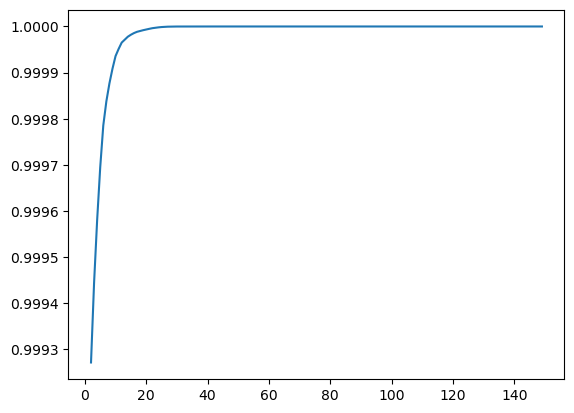

In [57]:
from sklearn.decomposition import PCA

var_ratio = {}
for n in range(2, 150):
    pca = PCA(n_components=n)
    df_pca = pca.fit(X_pca)
    var_ratio[n] = sum(df_pca.explained_variance_ratio_)

pd.Series(var_ratio).plot()

<Figure size 500x500 with 0 Axes>

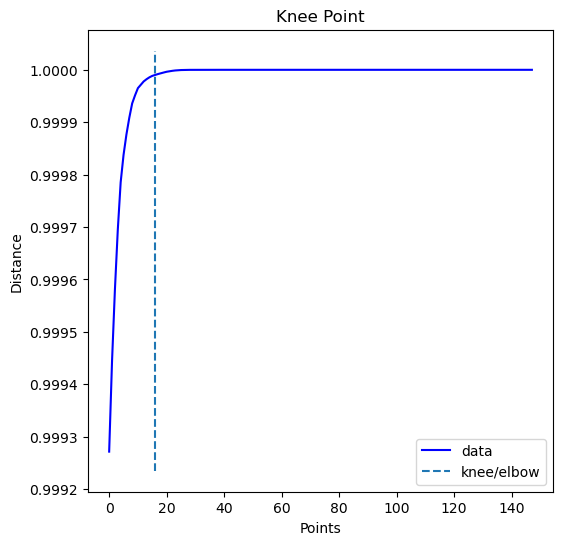

Knee Locator k: 18


In [59]:
from kneed import KneeLocator

i = np.arange(len(var_ratio))
variance_ratio = list(var_ratio.values())
components = list(var_ratio.keys())
knee = KneeLocator(i, variance_ratio, S=1, curve="concave", interp_method="polynomial")
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()
k = components[knee.knee]
print("Knee Locator k:", k)

In [61]:
pca_final = PCA(n_components=18, random_state=42).fit(X_res)

reduced = pca_final.fit_transform(X_pca)

In [62]:
smt = SMOTETomek(random_state=42, sampling_strategy="minority", n_jobs=-1)

X_res, y_res = smt.fit_resample(reduced, y)

In [63]:
report_pca = evaluate_models(X_res, y_res, models)

Random Forest
Model performance for training set
Accuracy: 0.9991
Precision: 1.0000
Recall: 0.9982
F1-Score: 0.9991
ROC-AuUC-Score: 0.9991
Cost: 4370
-----------------------------------------------------
Model performance for testing set
Accuracy: 0.9864
Precision: 0.9820
Recall: 0.9907
F1-Score: 0.9864
ROC-AuUC-Score: 0.9865
Cost: 7510


Decision Tree
Model performance for training set
Accuracy: 0.9991
Precision: 1.0000
Recall: 0.9982
F1-Score: 0.9991
ROC-AuUC-Score: 0.9991
Cost: 4370
-----------------------------------------------------
Model performance for testing set
Accuracy: 0.9792
Precision: 0.9748
Recall: 0.9835
F1-Score: 0.9791
ROC-AuUC-Score: 0.9793
Cost: 12560


Gradient Boosting
Model performance for training set
Accuracy: 0.9407
Precision: 0.9433
Recall: 0.9381
F1-Score: 0.9407
ROC-AuUC-Score: 0.9407
Cost: 172220
-----------------------------------------------------
Model performance for testing set
Accuracy: 0.9393
Precision: 0.9397
Recall: 0.9377
F1-Score: 0.9387
ROC-Au

In [64]:
report_pca

,Model Name,Cost
0,Random Forest,7510
5,XGB Classifier,11840
1,Decision Tree,12560
6,Catboost Classifier,12980
4,K-Neighbors Classifier,18690
2,Gradient Boosting,43250
7,Adaboost Classifier,64780
3,Logistic Regression,107240


##### Final Model

In [68]:
from prettytable import PrettyTable

pt = PrettyTable()
pt.field_names=["Model", "Imputation Method", "Total Cost"]
pt.add_row(["XGB Classifier", "KNN Imputer", "910"])
pt.add_row(["XGB Classifier", "Simple Imputer Median", "970"])
pt.add_row(["XGB Classifier", "MICE", "1020"])
pt.add_row(["XGB Classifier", "Simple Imputer Constant", "910"])
pt.add_row(["XGB Classifier", "Simple Imputer Mean", "1030"])
pt.add_row(["Random Forest", "PCA", "7510"])
print(pt)

+----------------+-------------------------+------------+
|     Model      |    Imputation Method    | Total Cost |
+----------------+-------------------------+------------+
| XGB Classifier |       KNN Imputer       |    910     |
| XGB Classifier |  Simple Imputer Median  |    970     |
| XGB Classifier |           MICE          |    1020    |
| XGB Classifier | Simple Imputer Constant |    910     |
| XGB Classifier |   Simple Imputer Mean   |    1030    |
| Random Forest  |           PCA           |    7510    |
+----------------+-------------------------+------------+


##### Final Report:
* The XGB Classifier with simple imputer with strategy constant has the least cost of 910 with an accuracy of 99.75%